In [1]:
import json
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

os.chdir("..")
from src.config import Config

In [2]:
config = Config("config/config.yaml")
path = config.datasets.path
bh_path = path + '/' + config.datasets.brennan_hale.path + '/easycap_M10.txt'
br_path = path + '/' + config.datasets.broderick.path + '/EEG/biosemi128.txt'
mappping_path = path + '/' + 'electrode_mapping.json'

In [3]:
def read_data(path):
    electrodes = {}
    with open(path, "r") as file:
        for line in file:
            if line.startswith("Site"):
                continue
            parts = line.strip().split()
            if len(parts) == 3:
                site, theta, phi = parts
                coordinates = [float(theta), float(phi)]
                electrodes[site] = coordinates
    return electrodes

def read_mapping(path):
    with open(path, "r") as file:
        mapping = json.load(file)
    return mapping

def get_indices(site2site):
    indices = [0] * len(site2site)
    for s1, s2 in site2site.items():
        indices[int(s1)] = int(s2)
    return indices

def spherical_to_cartesian(data, r=9):
    theta = data[:, 0]
    phi = data[:, 1]
    theta = np.deg2rad(theta)
    phi = np.deg2rad(phi)

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    return np.column_stack((x, y, z))

In [4]:
bh = read_data(bh_path)
br = read_data(br_path)
mapping = read_mapping(mappping_path)

bh_spherical = np.array(list(bh.values()))
idx = np.array(get_indices(mapping))
br_spherical = np.array(list(br.values()))[idx]

br_cartesian = spherical_to_cartesian(br_spherical)
bh_cartesian = spherical_to_cartesian(bh_spherical)

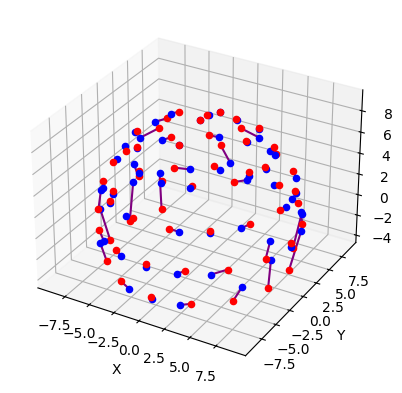

In [5]:
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for p1, p2 in zip(br_cartesian, bh_cartesian):
    ax.scatter(*p1, color='b')
    ax.scatter(*p2, color='r')
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='purple')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [6]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=br_cartesian[:, 0],
    y=br_cartesian[:, 1],
    z=br_cartesian[:, 2],
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='Broderick'
))

fig.add_trace(go.Scatter3d(
    x=bh_cartesian[:, 0],
    y=bh_cartesian[:, 1],
    z=bh_cartesian[:, 2],
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Brennan & Hale'
))


for p1, p2 in zip(br_cartesian, bh_cartesian):
    fig.add_trace(go.Scatter3d(
        x=[p1[0], p2[0]],
        y=[p1[1], p2[1]],
        z=[p1[2], p2[2]],
        mode='lines',
        line=dict(color='purple', width=2),
        showlegend=False
    ))


fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='EEG Electrode Mapping',
    autosize=False,
    width=600,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()